In [1]:
##############################################################################
# Handle imports
##############################################################################
from docling.document_converter import DocumentConverter
import traceback
from collections.abc import Iterable
import os
import pypdfium2 as pdfium
import re
import json
import jsonlines
import uuid
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, AIMessagePromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from deepeval.models.base_model import DeepEvalBaseLLM
from deepeval import assert_test
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, AnswerRelevancyMetric
from deepeval import evaluate
import xml.etree.ElementTree as etree
from longdocfactscore.ldfacts import LongDocFACTScore
from huggingface_hub import HfApi
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
import nltk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
nltk.download('punkt_tab')
from dotenv import load_dotenv
load_dotenv()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
##############################################################################
# Set up variables
##############################################################################
SOURCE_DIR="source_docs"
SOURCE_DIR_CHUNKED="source_docs_chunked"
MARKDOWN_DIR="markdown"
MARKDOWN_URI_PREFIX="https://raw.githubusercontent.com/agapebondservant/code-generation-capstone/refs/heads/main/eda/resources"
REPORT_DIR="reports"
OUTPUT_DIR="output"
INVALID_DIR="invalid"
ERROR_DIR="error" 
MODEL_DIR="models"
MODEL_IDS = ["ibm-granite/granite-8b-code-instruct-4k","ibm-granite/granite-8b-code-base-128k"]
DEVICE="cuda"
DATASET_REPO=f"{os.getenv('HF_USERNAME')}/codegen"

In [3]:
##############################################################################
# Set up object instances
##############################################################################

data_generator_llm = ChatOpenAI(
    model=os.getenv("DATA_GENERATOR_MODEL_ID"), # os.getenv('QWEN25CODER_MODEL_ID'),
    api_key=os.getenv('OPENROUTER_TOKEN'),
    base_url=os.getenv('OPENROUTER_API_BASE'),
    temperature=0.1,
)

class DataGeneratorLLM(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Data Generator LLM (GPT-OSS)"

evaluator_llm = DataGeneratorLLM(data_generator_llm)

### Data Conversion
The following pipeline is executed:
- A set of pdf files is collected from the source directory.
- The pdf files are split up into individual chapters.
- Each chapter is converted into markdown using a smart OCR tool (<a href="https://github.com/docling-project/docling" target="_blank">Docling</a>).

In [4]:
##############################################################################
# DATA EXTRACTION
##############################################################################
def get_chapter_ranges(sourcefilename, do_print=True):
    """
    Returns a list of (beginPage, endPage) ranges for chunks that represent chapters in the given pdf.
    """
    print("Getting chapter ranges...\n")
    
    pdf = pdfium.PdfDocument(sourcefilename)
    
    chapters = []
    
    begin, end = None, None
    
    for item in pdf.get_toc():
        boundary = None
        
        if item.page_index and ((item.n_kids == 0 and item.level < 2) or item.level == 2):
            if begin is not None:
                
                end = item.page_index - 1
                
                boundary = [begin, max(begin, end)]
                
                chapters.append([item.title, boundary])
                
            begin = item.page_index
            
    return chapters

In [5]:
def split_chapters(sourcefilename, targetfilename, pagerange):
    """
    Splits the pdf into chapters using the provided page ranges.
    Returns the name of the new pdf chunk.
    """
    try:
        source_pdf = pdfium.PdfDocument(sourcefilename)
        
        new_pdf = pdfium.PdfDocument.new()
    
        print(f"Saving chapter...{targetfilename}, Pages {pagerange[0]} to {pagerange[1]}")
        
        new_page_index = new_pdf.import_pages(source_pdf, pages=list(range(pagerange[0], pagerange[1]+1)))
        
        new_pdf.save(targetfilename)
        
        source_pdf.close()
        
        new_pdf.close()
        
    except Exception as e:
        print(f"Error saving {targetfilename}: {e}")

In [6]:
def convert_to_markdown(pdffile, markdownfile):
    """
    Converts the given PDF file into a Markdown file.
    """
    try:
        converter = DocumentConverter()
        
        result = converter.convert(pdffile)
        
        markdown_output = result.document.export_to_markdown()
    
        with open(markdownfile, "w") as file:
            file.write(markdown_output)
    
        print(f"{markdownfile} generated.")

        return markdown_output
            
    except Exception as e:
        print(f"Error saving {markdownfile}: {e}")

In [7]:
def get_code_snippets(content):
    """
    Parses out code sections of the markdown file.
    """
    
    code_snippets = re.findall(r'```([^`]+)```', content, re.DOTALL)

    return code_snippets

In [8]:
def generate_report(data, reportname, header=None):
    """
    Writes the given data to a report file with the given name.
    """
    try:
        with open(reportname, "a") as file:

            if header:
                file.write(header + "\n")
            
            if isinstance(data, Iterable):
                
                file.write("\n".join([str(d) for d in data]))
            else:
                
                file.write(data)
                
    except Exception as e:
        print(f"Error generating report {reportname}: {e}")

### Generate code-text pairs
The following code-text pairs will be generated:
- Code-to-markdown
- Code-to-functional-requirements
- Code-to-business-requirements
- Code-to-topics
- Code-to-components (JavaBeans, Controllers, Views, Custom Tags)
- Code-to-domain-model
- Code-to-summary

In [9]:
###################################
# Prompts
###################################
SYSTEM_PROMPT = """
    You are an expert software engineer with extensive experience in developing applications in many different languages.
    {prompt1}
    
    Code to analyze:
"""

SUMMARY_PROMPT = """
    Your task is to analyze this code snippet and provide a brief explanation of the code.
    
    Instructions:
    1. Provide a concise explanation that summarizes the purpose of the code without getting into too many specific technical details.
    2. **Format your response clearly and concisely** using a numbered list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
"""

SUMMARY_EVAL_PROMPT = SUMMARY_PROMPT

FUNCTIONAL_REQUIREMENTS_PROMPT = """
    Summarized Explanation:
    {output1}
    
    Using the summarized explanation above, generate an outline of functional requirements that might be connected to the code.
    
    Instructions:
    1. **Provide a short list of relevant requirements.** Do not include requirements that are not related to the code.
    2. **Format your response clearly and concisely** using a numbered list.
    3. **Only list functional requirements**: other kinds of requirements, such as business requirements, should not be included.
    4. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
"""

FUNCTIONAL_REQUIREMENTS_REFINER_PROMPT = """
    Requirements:
    {output2}
    
    Rewrite the functional requirements above without any of the details that link it to a specific programming language or framework, 
    such as Java or JSP.
"""

FUNCTIONAL_REQUIREMENTS_EVAL_PROMPT = """
    Generate an outline of functional requirements that might be connected to the code.
    
    Instructions:
    1. **Provide a short list of relevant requirements.** Do not include requirements that are not related to the code.
    2. **Format your response clearly and concisely** using a numbered list.
    3. **Only list functional requirements**: other kinds of requirements, such as business requirements, should not be included.
    4. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
    5. Also exclude any details that link the requirements to Java or JSP.
"""

BUSINESS_REQUIREMENTS_PROMPT = """
    Summarized Explanation:
    {output1}
    
    Using the summarized explanation above, generate an outline of sample business requirements that might be connected to the code.

    Instructions:
    
    1. **Provide a short list of relevant requirements.** Do not include requirements that are not related to the code.
    2. **Format your response clearly and concisely** using a numbered list.
    3. **Only list business requirements:** other kinds of requirements, such as functional requirements, should not be included.
    4. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
"""

BUSINESS_REQUIREMENTS_REFINER_PROMPT = """
    Requirements:
    {output2}
    
    Rewrite the business requirements above using more concise language. 
    Also exclude any details that link the requirements to Java or JSP.
"""

BUSINESS_REQUIREMENTS_EVAL_PROMPT = """
    Generate an outline of sample business requirements that might be connected to the code.

    Instructions:
    
    1. **Provide a short list of relevant requirements.** Do not include requirements that are not related to the code.
    2. **Format your response clearly and concisely** using a numbered list.
    3. **Only list business requirements:** other kinds of requirements, such as functional requirements, should not be included.
    4. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
    5. Also exclude any details that link the requirements to Java or JSP.
"""

TOPICS_PROMPT = """
    Summarized Explanation:
    {output1}
    
    Using the summarized explanation above, analyze this code snippet and generate a list of programming topics that are related to the code.
    
    Instructions:
    1. **Provide a short list of topics that you can identify.**
    2. **Format your response clearly and concisely** using a numbered list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
    
"""

TOPICS_REFINER_PROMPT = """
    Topics:
    {output2}
    
    Rewrite the programming topics above using more concise language. 
    Also exclude any details that link the requirements to Java or JSP. 
"""

TOPICS_EVAL_PROMPT = """
    Analyze this code snippet and generate a list of programming topics that are related to the code.
    
    Instructions:
    1. **Provide a short list of topics that you can identify.**
    2. **Format your response clearly and concisely** using a numbered list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
    
"""

COMPONENTS_PROMPT = """
    Your task is to analyze this code snippet and generate a specification of all the components you can find, 
    such as Model Components or JavaBeans, Controllers, Views, JSTL tags, Scriplets, etc.
    
    Instructions:
    1. **Provide an overview of all the components that you can find.**
    2. **Format your response clearly and concisely** using a numbered list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
"""

COMPONENTS_EVAL_PROMPT = COMPONENTS_PROMPT

DOMAIN_PROMPT = """
    Your task is to analyze this code snippet and generate an outline of the domain model associated with this code.
    
    Instructions:
    1. Avoid getting into too many specific technical details. Simply provide a domain model of the code.
    2. **Format your response clearly and concisely** using a numbered list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
    4. Include the current state of the domain objects based on information extracted from the code.
"""

DOMAIN_EVAL_PROMPT = DOMAIN_PROMPT

KEYWORDS_PROMPT = """
    Your task is to analyze this code snippet and generate a list of keywords that are associated with the code.
    
    Instructions:
    1. **Provide a short list of one-word keywords.**
    2. **Format your response clearly and concisely** using a comma-delimited list.
    3. If the provided snippet does not appear to be a code snippet, say THIS IS NOT VALID CODE.
"""

KEYWORDS_EVAL_PROMPT = KEYWORDS_PROMPT

PLACEHOLDER_PROMPT = """
    Write THIS IS A PLACEHOLDER.
"""

In [10]:
###################################
# Tree of prompts
###################################
prompt_tree = [
    {
        
        "prompt1": SUMMARY_PROMPT,
        
        "prompt2": FUNCTIONAL_REQUIREMENTS_PROMPT,
            
        "prompt3": FUNCTIONAL_REQUIREMENTS_REFINER_PROMPT, 

        "prompteval": FUNCTIONAL_REQUIREMENTS_EVAL_PROMPT,
        
        "code_type": "functional_requirements",
    },
    {   
        "prompt1": SUMMARY_PROMPT,
        
        "prompt2": BUSINESS_REQUIREMENTS_PROMPT,
            
        "prompt3": BUSINESS_REQUIREMENTS_REFINER_PROMPT,

        "prompteval": BUSINESS_REQUIREMENTS_EVAL_PROMPT,
        
        "code_type": "business_requirements",
    },
    {   
        "prompt1": SUMMARY_PROMPT,
        
        "prompt2": TOPICS_PROMPT,
            
        "prompt3": TOPICS_REFINER_PROMPT, 

        "prompteval": TOPICS_EVAL_PROMPT,
        
        "code_type": "topics",
    },
    {   
        "prompt1": PLACEHOLDER_PROMPT,
        
        "prompt2": PLACEHOLDER_PROMPT,
            
        "prompt3": COMPONENTS_PROMPT, 

        "prompteval": COMPONENTS_EVAL_PROMPT,
        
        "code_type": "components",
    },
    {   
        "prompt1":PLACEHOLDER_PROMPT,
        
        "prompt2": PLACEHOLDER_PROMPT,
            
        "prompt3": DOMAIN_PROMPT, 

        "prompteval": DOMAIN_EVAL_PROMPT,
        
        "code_type": "domain",
    },
    {   
        "prompt1": PLACEHOLDER_PROMPT,
        
        "prompt2": PLACEHOLDER_PROMPT,
        
        "prompt3": KEYWORDS_PROMPT,

        "prompteval": KEYWORDS_EVAL_PROMPT,
        
        "code_type": "keywords",
    },
    {   
        "prompt1": PLACEHOLDER_PROMPT,
        
        "prompt2": PLACEHOLDER_PROMPT,
        
        "prompt3": SUMMARY_PROMPT,

        "prompteval": SUMMARY_EVAL_PROMPT,
        
        "code_type": "summary",
    }
]

In [11]:
###################################
# Validation and Evaluation functions
###################################
def get_validation_issues(item):
    """
    Returns a list of validation issues associated with this item,
    or an empty list if no validation issues were found.
    """
    issues = []
    
    #########################
    # 1. Check if valid json
    #########################
    try:
        
        json.dumps(item)
        
    except Exception as e:
        
        issues.append(f"{str(item)},Invalid JSON")

    #########################
    # 2. Check missing values
    #########################
    if None in item.values():

        issues.append(f"{json.dumps(item)},Missing Values")

    #########################
    # 3. Check valid JSP code
    #########################
    if "THIS IS NOT VALID CODE" in item.values():

        issues.append(f"{json.dumps(item)},Invalid Code")

    return issues
        

def evaluate_dataset_entry(item):
    """
    Evaluates the given item with automated metrics.
    The following metrics are evaluated:
    1. For Coherence: G-Eval (LLM-as-Judge)
    2. For Relevancy: G-Eval (LLM-as-Judge)
    """

    evaluations = {
        "coherence": {},
        "relevancy": {},
    }

    ##################################################
    # 1. Measuring Coherence metric with G-eval
    ##################################################

    for prompt_node in prompt_tree:

        code_type = prompt_node["code_type"]

        evaluation_prompt = prompt_node["prompteval"]
    
        test_case = LLMTestCase(
            
            input=f"{evaluation_prompt}\nCode:{str(item["code"])}",
            
            actual_output=f"{item[code_type]}",
        ) 
    
        coherence_metric = GEval(
            name="Coherence",
            
            criteria="Determine if the actual output flows logically from the given input.",
            
            evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
            
            threshold=0.5,
            
            strict_mode=False,
            
            verbose_mode=False, 
            
            model=evaluator_llm
        )
    
        relevancy_metric = AnswerRelevancyMetric(
            include_reason=True,
            
            model=evaluator_llm,
            
            threshold=0.5,
            
            strict_mode=False,
    
            verbose_mode=False, 
        )
        
        coherence_metric.measure(test_case)
        
        evaluations["coherence"][code_type] = {"score": coherence_metric.score, "reason": coherence_metric.reason}

        relevancy_metric.measure(test_case)
        
        evaluations["relevancy"][code_type] = {"score": relevancy_metric.score, "reason": relevancy_metric.reason}

    return evaluations

In [12]:
###################################
# Utility functions
###################################

def llm_tool(inputs, chain_of_thought_len=1):
    """
    Invokes LLM with given input.
    """

    chain, chain_with_next, prompt = None, None, None

    for idx in range(1,chain_of_thought_len+1):
        
        if idx == 1:
            
            prompt = ChatPromptTemplate.from_messages(
                [
                    SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT),
                    
                    HumanMessagePromptTemplate.from_template("{input}"),
                ]
            )

            chain = prompt | data_generator_llm

            output = f"output{idx}"

            chain_with_next = {output: chain | StrOutputParser(), **{f"prompt{i+1}": RunnablePassthrough() for i in range(chain_of_thought_len)}}
            
        else:

            promptid = f"{{prompt{idx}}}"

            prompt = ChatPromptTemplate.from_messages(
                [   
                    AIMessagePromptTemplate.from_template(promptid),
                ]
            )

            if idx == chain_of_thought_len:
            
                chain = (chain_with_next or chain) | prompt | data_generator_llm
                
            else:

                output = f"output{idx}"

                chain = (chain_with_next or chain) | {output: prompt | data_generator_llm | StrOutputParser()}
            
         
    responses = chain.batch(inputs)
    
    return responses

def build_code_completion_pair(snippet, doc, metadata={}, outputfilename="data"):
    """
    Generates code-completion pairs from the given doc.
    """

    try:
        item = {
            "id": str(uuid.uuid4()),
            
            "metadata": metadata,
            
            "code": snippet,
            
            "section": doc.page_content,
        }
    
        inputs = [{"input": snippet, **p} for p in prompt_tree]
         
        responses = llm_tool(inputs, chain_of_thought_len=3)

        for idx, response in enumerate(responses):

            code_type = inputs[idx]["code_type"]
            
            item[code_type] = response.content

        validation_issues = get_validation_issues(item)

        if validation_issues:

            with open(f"{INVALID_DIR}/{outputfilename}.txt", 'a') as f:
                
                f.writelines(map(lambda x: x + "\n", validation_issues))

        item["metadata"]["evaluations"] = evaluate_dataset_entry(item)

        with open(f"{OUTPUT_DIR}/{outputfilename}.jsonl", 'a') as f:
        
            json_line = json.dumps(item)
        
            f.write(json_line + '\n')     
        
    except Exception as e:
        
        print(f"Error writing snippet {snippet}: {e}")
        
        traceback.print_exc() 

        with open(f"{ERROR_DIR}/{outputfilename}.txt", 'a') as f:
            
            f.write(snippet + ',' + e + '\n')


In [13]:
def split_markdown_sections(markdownfilename, outputfilename, content=None):

    try:
    
        if content is None:
            
            with open(markdownfilename, mode="r") as f: 
                content = f.read()
                
        headers_to_split = [("#", "Header 1"), ("##", "Header 2"),("###", "Header 3")]
        
        text_splitter = MarkdownHeaderTextSplitter(headers_to_split, strip_headers=False)
        
        splits = text_splitter.split_text(content)
            
        for i, split in enumerate(splits):
            
            sections = get_code_snippets(split.page_content)
        
            if sections:

                print(f"Processing split {i} in {markdownfilename}...")

                for section in sections:
        
                    build_code_completion_pair(section, 
                                               
                                               split, 
                                               
                                               metadata={"source": f"{MARKDOWN_URI_PREFIX}/{markdownfilename}"} | split.metadata, 
                                               
                                               outputfilename=outputfilename)
            else:
                
                print(f"Skipping split {i} in {markdownfilename} - no code snippets found...")
                
    except Exception as e:
        
        print(f"Error handling markdown section {markdownfilename}: {e}")
        
        traceback.print_exc() 
    

### Run the pipeline
Execute the pipeline!

In [14]:
def data_extraction_pipeline(output_file):
    """
    Executes the full data extraction pipeline.
    """
    [os.makedirs(dirname, exist_ok=True) for dirname in [
        SOURCE_DIR, 
        SOURCE_DIR_CHUNKED, 
        MARKDOWN_DIR, 
        REPORT_DIR, 
        OUTPUT_DIR,
        INVALID_DIR,
        ERROR_DIR
    ]]
    
    source_files = [f for f in os.listdir(SOURCE_DIR) if ".pdf" in f]
    
    for file in source_files:

        try:
            pass
            # chapters = get_chapter_ranges(f"{SOURCE_DIR}/{file}", do_print=False)
    
            # generate_report(chapters, f"{REPORT_DIR}/chapters.txt", "Title,Page Range")
            
            # for idx, [title, _range] in enumerate(chapters):
                
            #     pdf = f"{SOURCE_DIR_CHUNKED}/{idx}_{file}"
                
            #     md = f"{MARKDOWN_DIR}/{idx}_{file.replace('.pdf', '.md')}"
                
            #     # split_chapters(f"{SOURCE_DIR}/{file}", pdf, _range)
                
            #     # content = convert_to_markdown(pdf, md)
    
            #     # split_markdown_sections(md, output_file)

        except Exception as e:
        
            print(f"Error handling {SOURCE_DIR}/{file}: {e}")

            

In [15]:
# output_file_name=f"data{datetime.now().strftime('%Y%m%d%H%M')}"

output_file_name='data202510292018'
ORIGINAL_DATA_JSONL = []

# data_extraction_pipeline(output_file_name) 

### Explore the generated data
Perform exploratory data analysis on the data. This includes the following:
- **Descriptive statistics** about the data
- **Percentage** of records with missing data
- **Percentage** of records with "invalid code" errors
    - (Might use confusion matrix if possible)
- **Percentage** of records with failed evaluation metrics based on
    - Relevance (automated)
    - Consistency (automated)
    - (Might use confusion matrix if possible)

In [16]:
###################################
# Evaluate training dataset
###################################

df = pd.read_json(f"{OUTPUT_DIR}/{output_file_name}.jsonl", lines=True)
df = pd.concat([df, pd.json_normalize(df['metadata'])], axis=1)


##############################################################################
# Descriptive stats
##############################################################################
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 41 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   id                                                    346 non-null    object 
 1   metadata                                              346 non-null    object 
 2   code                                                  346 non-null    object 
 3   section                                               346 non-null    object 
 4   functional_requirements                               346 non-null    object 
 5   business_requirements                                 346 non-null    object 
 6   topics                                                346 non-null    object 
 7   components                                            346 non-null    object 
 8   domain                                                346 no

#### Analysis:
The raw dataset consists of 346 records. There are no null fields.

In [17]:
##############################################################################
# General statistics
##############################################################################
n_records = len(df)
n_features = len(df.columns)
n_evaluation_features = len(df.filter(regex="^evaluations").columns)
n_disk_size = round(os.path.getsize(f"{OUTPUT_DIR}/{output_file_name}.jsonl")/(1024*1024),1)
n_percent_of_raw_data = round(n_disk_size / 11.6 * 100,1)
n_categorical_variables = len(df.select_dtypes(exclude=np.number).columns)
n_numerical_variables = len(df.select_dtypes(include=np.number).columns)


print(f"""
Total number of records: {n_records}
Size on disk: {n_disk_size}MB
Percentage extracted from raw source: {n_percent_of_raw_data}%
Number of categorical variables: {n_categorical_variables}
Number of numerical variables: {n_numerical_variables}
Total Features: {n_features} (Evaluation Features: {n_evaluation_features}, Non-Evaluation Features: {n_features - n_evaluation_features})
{"\n".join([f"- {col}" for col in df.columns])}
""")


Total number of records: 346
Size on disk: 3.3MB
Percentage extracted from raw source: 28.4%
Number of categorical variables: 27
Number of numerical variables: 14
Total Features: 41 (Evaluation Features: 28, Non-Evaluation Features: 13)
- id
- metadata
- code
- section
- functional_requirements
- business_requirements
- topics
- components
- domain
- keywords
- summary
- source
- Header 2
- evaluations.coherence.functional_requirements.score
- evaluations.coherence.functional_requirements.reason
- evaluations.coherence.business_requirements.score
- evaluations.coherence.business_requirements.reason
- evaluations.coherence.topics.score
- evaluations.coherence.topics.reason
- evaluations.coherence.components.score
- evaluations.coherence.components.reason
- evaluations.coherence.domain.score
- evaluations.coherence.domain.reason
- evaluations.coherence.keywords.score
- evaluations.coherence.keywords.reason
- evaluations.coherence.summary.score
- evaluations.coherence.summary.reason
- ev

#### Analysis:
- There are **346** total records in the raw dataset, representing 3.3MB in total disk size. This represents about **28.9%** of the original corpus that was extracted for the code generation task. The data extraction process involved filtering the corpus down to chunks with code snippets.
- There are **27** categorical features and **14** numeric features. All numeric features are associated with the evaluation metric scores. The categorical variables are non-discrete.
- There are **41** total features associated with this dataset, including **13** core features and **28** evaluation features.
- **Core features**:
    - **id**: Unique identifier.
    - **metadata**: Dictionary containing metadata about the record
    - **code**: Freetext code snippet associated with the record.
    - **section**: Plaintext chunk associated with the record.
    - **functional_requirements**: Freetext outline of functional requirements that were autogenerated based on LLM code snippet analysis. 
    - **business_requirements**: Freetext outline of business requirements that were autogenerated based on LLM code snippet analysis.
    - **topics**: Freetext outline of relevant topics that were autogenerated based on LLM code snippet analysis.
    - **components**: Freetext outline of JSP-relevant code components that were detected based on LLM code snippet analysis.
    - **domain**: Freetext outline of domain model that was autogenerated based on LLM code snippet analysis.
    - **keywords**: Freetext comma-delimited list of keywords that were autogenerated based on LLM code snippet analysis.
    - **summary**: Freetext comma-delimited code summary that was autogenerated based on LLM code snippet analysis.
    - **source**: URI of associated markdown file.
    - **Header 2**: Associated markdown header title.
- **Evaluation features**: (All evaluated on a scale of 0 to 1)
    - **evaluations.coherence.functional_requirements.score**: Coherence metric for functional requirements.
    - **evaluations.coherence.functional_requirements.reason**: Coherence metric reason for functional requirements.
    - **evaluations.coherence.business_requirements.score**: Coherence metric for business requirements.
    - **evaluations.coherence.business_requirements.reason**: Coherence metric reason for functional requirements.
    - **evaluations.coherence.topics.score**: Coherence metric for topics.
    - **evaluations.coherence.topics.reason**: Coherence metric reason for topics.
    - **evaluations.coherence.components.score**: Coherence metric for JSP components.
    - **evaluations.coherence.components.reason**: Coherence metric reason for JSP components.
    - **evaluations.coherence.domain.score**: Coherence metric for domain model.
    - **evaluations.coherence.domain.reason**: Coherence metric reason for domain model.
    - **evaluations.coherence.keywords.score**: Coherence metric for keywords.
    - **evaluations.coherence.keywords.reason**: Coherence metric reason for keywords.
    - **evaluations.coherence.summary.score**: Coherence metric for code summary.
    - **evaluations.coherence.summary.reason**: Coherence metric reason for code summary.
    - **evaluations.relevancy.functional_requirements.score**: Relevancy metric for functional requirements.
    - **evaluations.relevancy.functional_requirements.reason**: Relevancy metric reason for functional requirements.
    - **evaluations.relevancy.business_requirements.score**: Relevancy metric for business requirements.
    - **evaluations.relevancy.business_requirements.reason**: Relevancy metric reason for business requirements.
    - **evaluations.relevancy.topics.score**: Relevancy metric for topics.
    - **evaluations.relevancy.topics.reason**: Relevancy metric reason for topics.
    - **evaluations.relevancy.components.score**: Relevancy metric for JSP components.
    - **evaluations.relevancy.components.reason**: Relevancy metric reason for JSP components.
    - **evaluations.relevancy.domain.score**: Relevancy metric for domain model.
    - **evaluations.relevancy.domain.reason**: Relevancy metric reason for domain model.
    - **evaluations.relevancy.keywords.score**: Relevancy metric for keywords.
    - **evaluations.relevancy.keywords.reason**: Relevancy metric reason for keywords.
    - **evaluations.relevancy.summary.score**: Relevancy metric for code summary.
    - **evaluations.relevancy.summary.reason**: Relevancy metric reason for code summary.

### Data distributions
We explore the numerical variables in this case. The categorical variables will be converted into **word embeddings** in order to allow them to capture semantic meaning more fully. The numerical variables in this dataset are the evaluation scores. 

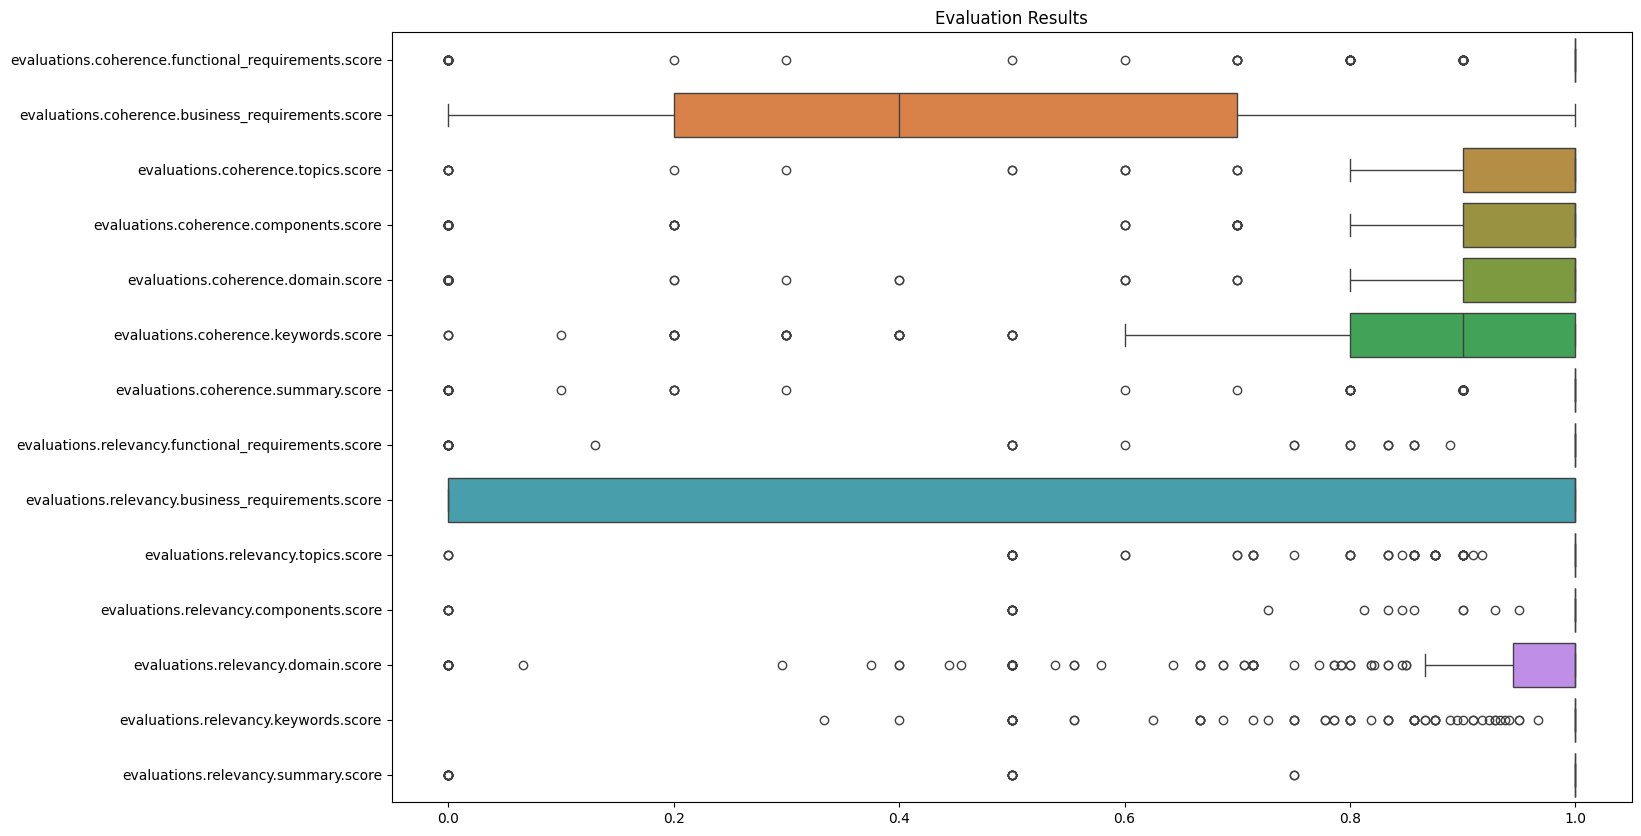

In [18]:
plt.figure(figsize = (16, 10))
evaluations_columns = df.filter(regex="^evaluations.+score").columns
sns.boxplot(data=df[evaluations_columns], orient='h')
plt.title('Evaluation Results')
plt.show()

In [65]:
evaluations_df = df.filter(regex='^evaluations.+score')
evaluations_stats = evaluations_df.describe().T.drop(columns=['count','max'])

evaluations_stats.insert(loc=3, column='20%', value=evaluations_df.quantile(0.20))
evaluations_stats.insert(loc=3, column='15%', value=evaluations_df.quantile(0.15))
evaluations_stats.insert(loc=3, column='10%', value=evaluations_df.quantile(0.10))
evaluations_stats.insert(loc=3, column='5%', value=evaluations_df.quantile(0.05))

business_requirements_mask = evaluations_stats.index.str.contains('business_requirements')

print(f"""
95% of the population scored {evaluations_stats[~business_requirements_mask]['5%'].min()} on at least 1 metric excluding business requirements
90% of the population scored {evaluations_stats[~business_requirements_mask]['10%'].min()} on at least 1 metric excluding business requirements
85% of the population scored {evaluations_stats[~business_requirements_mask]['15%'].min()} on at least 1 metric excluding business requirements
80% of the population scored {evaluations_stats[~business_requirements_mask]['20%'].min()} on at least 1 metric excluding business requirements

Mean evaluation scores ranked from highest to lowest:
{evaluations_stats.nlargest(20, 'mean')['mean']}
""")

evaluations_stats


95% of the population scored 0.0 on at least 1 metric excluding business requirements
90% of the population scored 0.0 on at least 1 metric excluding business requirements
85% of the population scored 0.55 on at least 1 metric excluding business requirements
80% of the population scored 0.8 on at least 1 metric excluding business requirements

Mean evaluation scores ranked from highest to lowest:
evaluations.relevancy.components.score                 0.963165
evaluations.relevancy.keywords.score                   0.954953
evaluations.relevancy.summary.score                    0.953757
evaluations.relevancy.topics.score                     0.952252
evaluations.relevancy.functional_requirements.score    0.936678
evaluations.coherence.topics.score                     0.930925
evaluations.coherence.summary.score                    0.919942
evaluations.coherence.functional_requirements.score    0.891329
evaluations.relevancy.domain.score                     0.883152
evaluations.coherence.c

,mean,std,min,5%,10%,15%,20%,25%,50%,75%
evaluations.coherence.functional_requirements.score,0.891329,0.278578,0.000000,0.000000,0.700000,0.875000,0.9,1.000000,1.0,1.0
evaluations.coherence.business_requirements.score,0.471387,0.318996,0.000000,0.000000,0.200000,0.200000,0.2,0.200000,0.4,0.7
evaluations.coherence.topics.score,0.930925,0.165232,0.000000,0.800000,0.800000,0.900000,0.9,0.900000,1.0,1.0
evaluations.coherence.components.score,0.869364,0.274814,0.000000,0.000000,0.700000,0.800000,0.8,0.900000,1.0,1.0
evaluations.coherence.domain.score,0.812139,0.338920,0.000000,0.000000,0.000000,0.550000,0.8,0.900000,1.0,1.0
evaluations.coherence.keywords.score,0.860983,0.207562,0.000000,0.325000,0.600000,0.700000,0.8,0.800000,0.9,1.0
evaluations.coherence.summary.score,0.919942,0.232892,0.000000,0.200000,0.900000,0.900000,0.9,1.000000,1.0,1.0
evaluations.relevancy.functional_requirements.score,0.936678,0.223157,0.000000,0.500000,0.944444,1.000000,1.0,1.000000,1.0,1.0
evaluations.relevancy.business_requirements.score,0.657743,0.440633,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,1.0
evaluations.relevancy.topics.score,0.952252,0.139982,0.000000,0.700000,0.857143,0.900000,1.0,1.000000,1.0,1.0


### Observations:

- When observing the evaluation scores, we observe that they are mostly **left skewed**. This implies that **most of the population scores well on the most of the evaluation metrics**, which is the preferred behavior for a quality dataset. The only exception to the left skewedness are the **business requirements** metric scores.
- For the following metrics, **30 or fewer** outliers out of a population of 346 did not score 1.0, implying that **92%** of the population scored a perfect score on these metrics:
    - evaluations.relevancy.components.score
    - evaluations.relevancy.summary.score
    - evaluations.relevancy.keywords.score
    - evaluations.relevancy.topics.score
    - evaluations.relevancy.functional_requirements.score
    - evaluations.coherence.summary.score
    - evaulations.coherence.functional_requirements.score
      
- For all metrics except the business requirements, the **20th** percentile of scores was 0.8, which means **80%** of the population scored **0.8 or more** on at least 1 of the metrics. It does **not** mean that 80% of the population scored 0.8 or more on **all** of the metrics. For example, Code Snippet A might score 0.9 on Summary Relevancy but 0.1 on Business Requirements Relevancy, and Code Snippet B might score 0.9 on Business Requirements Relevancy but 0.1 on Summary Relevancy. In this case, both samples scored 0.8 on at least 1 metric, but neither score 0.8 on both.
  
- The dataset tends to perform better with the **relevancy-based" metrics than the **coherence-based" metrics.
  
- The metrics with the greatest spread were **Coherence metric for keywords**, **Coherence metric for business requirements** and **Relevancy metric for business requirements**.
  
- We observe that
    - 95% of the population scored 0.0 on at least 1 metric excluding business requirements
    - 90% of the population scored 0.0 on at least 1 metric excluding business requirements
    - 85% of the population scored 0.55 on at least 1 metric excluding business requirements
    - 80% of the population scored 0.8 on at least 1 metric excluding business requirements
      
- From manual verification of the business requirements evaluation results:
    - The business requirements actually appear to be valid despite their lower scores. For example, for the generated requirements "1. The system must allow users to submit information via a web interface. 2. The system must provide immediate feedback to users after submission. 3. The system must ensure secure handling of user data. 4. The system must support concurrent user interactions without performance degradation. 5. The system must comply with applicable data protection regulations.", the evaluator generated a below-optimal score of 0.4 with this explanation: "The response provides a numbered list of business‑style requirements that are relevant to the servlet code and follows the requested format. However, it includes several functional requirements (e.g., submission handling, immediate feedback, concurrency support) that the instructions explicitly forbid, violating the rule to list only business requirements. This mismatch reduces the alignment score." In this case, the scorer has an overly strict definition of business vs technical requirements. Hence, it appears that the scorer has a **strict bias** and was **systematically underestimating** the scores.
    - For similar reasons, the coherence metric for the domain model appears to be valid.
  
- Based on the analysis above, we can:
    - Repeat the above analysis, but exclude the **coherence** metrics in the quantile analysis.
    - Add a new feature, **evaluation.min-score**, that captures the lowest score across all metrics for each sample. 

In [68]:
evaluations_df['evaluations.min-score'] = evaluations_df.drop(columns=business_requirements_columns, errors="ignore").min(axis=1)
evaluations_stats = evaluations_df.describe().T.drop(columns=['count','max'])

evaluations_stats.insert(loc=3, column='20%', value=evaluations_df.quantile(0.20))
evaluations_stats.insert(loc=3, column='15%', value=evaluations_df.quantile(0.15))
evaluations_stats.insert(loc=3, column='10%', value=evaluations_df.quantile(0.10))
evaluations_stats.insert(loc=3, column='5%', value=evaluations_df.quantile(0.05))

print(f"""
95% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['5%'].min()} on all metrics except business requirements and coherence
90% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['10%'].min()} on all metrics except business requirements and coherence
85% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['15%'].min()} on all metrics except business requirements and coherence
80% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['20%'].min()} on all metrics except business requirements and coherence
75% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['25%'].min()} on all metrics except business requirements and coherence
50% of the population scored at least {evaluations_stats.loc['evaluations.min-score']['50%'].min()} on all metrics except business requirements and coherence
""")

evaluations_stats


95% of the population scored at least 0.0 on all metrics except business requirements and coherence
90% of the population scored at least 0.0 on all metrics except business requirements and coherence
85% of the population scored at least 0.5 on all metrics except business requirements and coherence
80% of the population scored at least 0.5 on all metrics except business requirements and coherence
75% of the population scored at least 0.6000000000000001 on all metrics except business requirements and coherence
50% of the population scored at least 0.894444444444444 on all metrics except business requirements and coherence



,mean,std,min,5%,10%,15%,20%,25%,50%,75%
evaluations.coherence.functional_requirements.score,0.891329,0.278578,0.000000,0.000000,0.700000,0.875000,0.9,1.000000,1.000000,1.0
evaluations.coherence.business_requirements.score,0.471387,0.318996,0.000000,0.000000,0.200000,0.200000,0.2,0.200000,0.400000,0.7
evaluations.coherence.topics.score,0.930925,0.165232,0.000000,0.800000,0.800000,0.900000,0.9,0.900000,1.000000,1.0
evaluations.coherence.components.score,0.869364,0.274814,0.000000,0.000000,0.700000,0.800000,0.8,0.900000,1.000000,1.0
evaluations.coherence.domain.score,0.812139,0.338920,0.000000,0.000000,0.000000,0.550000,0.8,0.900000,1.000000,1.0
evaluations.coherence.keywords.score,0.860983,0.207562,0.000000,0.325000,0.600000,0.700000,0.8,0.800000,0.900000,1.0
evaluations.coherence.summary.score,0.919942,0.232892,0.000000,0.200000,0.900000,0.900000,0.9,1.000000,1.000000,1.0
evaluations.relevancy.functional_requirements.score,0.936678,0.223157,0.000000,0.500000,0.944444,1.000000,1.0,1.000000,1.000000,1.0
evaluations.relevancy.business_requirements.score,0.657743,0.440633,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
evaluations.relevancy.topics.score,0.952252,0.139982,0.000000,0.700000,0.857143,0.900000,1.0,1.000000,1.000000,1.0


### Observations
- We observe that:
    - 95% of the population scored at least 0.0 on all metrics except business requirements and coherence
    - 90% of the population scored at least 0.0 on all metrics except business requirements and coherence
    - 85% of the population scored at least 0.5 on all metrics except business requirements and coherence
    - 80% of the population scored at least 0.5 on all metrics except business requirements and coherence
    - 75% of the population scored at least 0.6 on all metrics except business requirements and coherence
    - 50% of the population scored at least 0.89 on all metrics except business requirements and coherence
      
- Based on this, we can perform manual data quality checks on the samples that scored between **0.5** and **0.89**.
    - If the data quality verification checks show that the samples are actually mostly valid, then we can truncate less data by dropping the cut-off threshold for the metrics as low as **0.5**.
    - If they show that the samples are not mostly valid, then we can truncate more data by raising the cut-off threshold for the metrics as high as **0.89**.

In [104]:
#################################################################
# Evaluating samples with evaluation scores between 0.5 and 0.6
#################################################################
excluded_columns = evaluations_df.filter(regex='.+business_requirements|coherence').columns
df_2 = evaluations_df.drop(columns=excluded_columns, errors="ignore")
results = df_2[((df_2[df_2.columns]>0.5) & (df_2[df_2.columns]<0.6)).any(axis=1)]
print(f"The number of samples with metrics scores between 0.5 and 0.6 is {len(results)}") 
results

The number of samples with metrics scores between 0.5 and 0.6 is 6


,evaluations.relevancy.functional_requirements.score,evaluations.relevancy.topics.score,evaluations.relevancy.components.score,evaluations.relevancy.domain.score,evaluations.relevancy.keywords.score,evaluations.relevancy.summary.score,evaluations.min-score
70,1.0,1.000000,1.0,0.538462,1.000000,1.0,0.538462
102,1.0,1.000000,1.0,0.555556,1.000000,1.0,0.555556
296,1.0,1.000000,1.0,0.555556,1.000000,1.0,0.555556
308,1.0,1.000000,1.0,0.578947,1.000000,1.0,0.578947
328,1.0,0.714286,1.0,1.000000,0.555556,1.0,0.555556
337,1.0,0.857143,1.0,1.000000,0.555556,1.0,0.555556


### Spot Checking
- From manual spot checking of the **jsonl** file, the samples associated with the scores between 0.5 and 0.6 do not appear to be underestimated.
- They appear to lack important information and should be truncated. Since it impacts only 6 records out of 345, it should be relatively safe to truncate.
    - Manual spot-checking samples: 70, 102, 328

In [79]:
#################################################################
# Evaluating samples with evaluation scores between 0.6 and 0.7
#################################################################
results = df_2[((df_2[df_2.columns]>0.6) & (df_2[df_2.columns]<0.7)).any(axis=1)]
print(f"The number of samples with metrics scores between 0.6 and 0.7 is {len(results)}") 
results

The number of samples with metrics scores between 0.6 and 0.7 is 15


,evaluations.relevancy.functional_requirements.score,evaluations.relevancy.topics.score,evaluations.relevancy.components.score,evaluations.relevancy.domain.score,evaluations.relevancy.keywords.score,evaluations.relevancy.summary.score,evaluations.min-score
7,1.000000,0.600000,1.0,1.000000,1.000000,1.0,0.600000
18,1.000000,0.600000,1.0,1.000000,0.894737,1.0,0.600000
22,1.000000,0.875000,1.0,0.666667,1.000000,1.0,0.666667
106,1.000000,0.714286,1.0,0.666667,1.000000,1.0,0.666667
119,1.000000,1.000000,1.0,1.000000,0.666667,1.0,0.666667
129,1.000000,1.000000,1.0,1.000000,0.666667,1.0,0.666667
147,0.600000,1.000000,1.0,1.000000,1.000000,1.0,0.600000
184,1.000000,1.000000,1.0,0.000000,0.666667,0.0,0.000000
201,1.000000,1.000000,0.9,0.500000,0.625000,1.0,0.500000
215,1.000000,0.875000,1.0,1.000000,0.666667,1.0,0.666667


### Spot Checking
- From manual spot checking of the **jsonl** file, the samples associated with the scores between 0.6 and 0.7 do not appear to be underestimated.
- They appear to include additional information, but the additional information was not entirely invalid. We could possibly retain these samples in the dataset.
    - Manual spot-checking samples: 7, 22, 201

In [80]:
#################################################################
# Evaluating samples with evaluation scores between 0.7 and 0.8
#################################################################
results = df_2[((df_2[df_2.columns]>0.7) & (df_2[df_2.columns]<0.8)).any(axis=1)]
print(f"The number of samples with metrics scores between 0.7 and 0.8 is {len(results)}") 
results

The number of samples with metrics scores between 0.7 and 0.8 is 36


,evaluations.relevancy.functional_requirements.score,evaluations.relevancy.topics.score,evaluations.relevancy.components.score,evaluations.relevancy.domain.score,evaluations.relevancy.keywords.score,evaluations.relevancy.summary.score,evaluations.min-score
11,1.000000,0.857143,1.000000,1.000000,0.785714,1.00,0.785714
12,1.000000,1.000000,0.812500,0.785714,1.000000,1.00,0.785714
27,1.000000,1.000000,1.000000,1.000000,0.750000,1.00,0.750000
29,0.750000,1.000000,1.000000,1.000000,1.000000,1.00,0.750000
30,1.000000,0.714286,1.000000,1.000000,1.000000,1.00,0.714286
34,0.888889,1.000000,1.000000,0.714286,1.000000,1.00,0.714286
61,1.000000,1.000000,1.000000,0.791667,1.000000,1.00,0.791667
74,1.000000,0.900000,1.000000,0.772727,1.000000,1.00,0.772727
76,1.000000,0.750000,1.000000,1.000000,1.000000,1.00,0.750000
83,1.000000,1.000000,1.000000,0.800000,0.727273,1.00,0.727273


### Spot Checking
- From manual spot checking of the **jsonl** file, the samples associated with the scores between 0.7 and 0.8 do not appear to be underestimated.
  
- They appear to include additional information, but the additional information was not entirely invalid. We should retain these samples in the dataset.
    - Manual spot-checking samples: 30, 193

### Invalid Code Samples
We will also filter samples that have been marked with the tag "THIS IS NOT VALID CODE" in any of their features.

In [84]:
invalid_code_mask = (df[df.columns]=="THIS IS NOT VALID CODE").any(axis=1)
invalid_code_df = df[invalid_code_mask]
valid_code_df = df[~invalid_code_mask]
print(f"The number of invalid code samples is {len(invalid_code_df)}.")
invalid_code_df

The number of invalid code samples is 16.


,id,metadata,code,section,functional_requirements,business_requirements,topics,components,domain,keywords,...,evaluations.relevancy.topics.score,evaluations.relevancy.topics.reason,evaluations.relevancy.components.score,evaluations.relevancy.components.reason,evaluations.relevancy.domain.score,evaluations.relevancy.domain.reason,evaluations.relevancy.keywords.score,evaluations.relevancy.keywords.reason,evaluations.relevancy.summary.score,evaluations.relevancy.summary.reason
24,eb3bd81a-c64e-47e8-a5e5-37a2fce8d2cb,{'source': 'https://raw.githubusercontent.com/...,\n}\n,## Listing 2.14 NetworkClient.java \n```\nimp...,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,...,0.500000,The score is 0.50 because the response include...,1.0,The score is 1.00 because the response fully a...,0.5,The score is 0.50 because the output contains ...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response fully a...
26,6d4e9033-ecb9-4fed-bbb1-666e5be67e94,{'source': 'https://raw.githubusercontent.com/...,\nListing 2.16 CloseableFrame.java\n,## CloseableFrame \nCloseableFrame is an exte...,1. Provide a mechanism to terminate a frame or...,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,...,0.500000,The score is 0.50 because the output contains ...,0.5,The score is 0.50 because the answer only cont...,0.0,The score is 0.00 because the output only cont...,0.5,The score is 0.50 because the output failed to...,1.0,The score is 1.00 because the response fully a...
58,32d9f3d6-5d99-49e2-bcec-a9ed38d13b19,{'source': 'https://raw.githubusercontent.com/...,\nListing 6.2 SearchSpec.java package coreserv...,## 6.3 A Front End to Various Search Engines ...,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,THIS IS NOT VALID CODE.,...,1.000000,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response directl...,0.5,The score is 0.50 because the output contains ...,1.0,The score is 1.00 because the assistant's resp...,0.5,The score is 0.50 because the output contains ...
60,8b3b6365-388c-4d9f-afa7-25a8675756f9,{'source': 'https://raw.githubusercontent.com/...,\nPrimeNumbers.java (continued)\n,## 7.3 Persistent Servlet State and Auto-Reloa...,**Functional Requirements (language‑agnostic)*...,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,...,0.500000,The score is 0.50 because the response contain...,1.0,The score is 1.00 because the assistant's resp...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response directl...,0.0,The score is 0.00 because the output contains ...
111,be285a69-9970-42f6-9e65-8960c1da8ae9,{'source': 'https://raw.githubusercontent.com/...,\n<jsp:scriptlet> Code </jsp:scriptlet>\n,## Special Scriptlet Syntax \nThere are two s...,THIS IS NOT VALID CODE.,THIS IS NOT VALID CODE,1. Web application development \n2. Server‑si...,1. **JSP Scriptlet Tag** – `<jsp:scriptlet> … ...,THIS IS NOT VALID CODE.,"jsp,scriptlet,java,web,server,tag",...,0.857143,The score is 0.86 because the answer included ...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response fully a...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response directl...
148,d222257b-cd64-4282-a70d-d1561e5fd354,{'source': 'https://raw.githubusercontent.com/...,\npackage coreservlets;\n,## Listing 13.7 AccessCountBean.java \n```\np...,1. None.,1. Enable secure user authentication and autho...,THIS IS NOT VALID CODE,1. **Package declaration** – `package coreserv...,THIS IS NOT VALID CODE.,"package, Java, servlet",...,0.500000,The score is 0.50 because the assistant includ...,1.0,The score is 1.00

In [ ]:
### Spot Checking
- From manual spot checking, the LLM-generated tags identifying the code as invalid appear to be accurate.
    
    - Manual Spot Checking examples: 24, 26, 222

### Conclusions  / Remediation
- The following actions will be taken based on the analysis above:
    - **Truncate** all records that scored **less than 0.6** on any metric excluding the business requirements and coherence metrics.
    - **Truncate** all records that include **THIS IS NOT VALID CODE** in any of their features.

In [106]:
filtered_evaluations_by_metrics = df_2[(df_2[df_2.columns]<0.6).any(axis=1)]
filtered_df = df.drop(filtered_evaluations_by_metrics.index).drop(invalid_code_df.index, errors="ignore")
filtered_df

,id,metadata,code,section,functional_requirements,business_requirements,topics,components,domain,keywords,...,evaluations.relevancy.topics.score,evaluations.relevancy.topics.reason,evaluations.relevancy.components.score,evaluations.relevancy.components.reason,evaluations.relevancy.domain.score,evaluations.relevancy.domain.reason,evaluations.relevancy.keywords.score,evaluations.relevancy.keywords.reason,evaluations.relevancy.summary.score,evaluations.relevancy.summary.reason
1,aa5c698f-8ec0-44c2-9751-ed693e461c84,{'source': 'https://raw.githubusercontent.com/...,\nListing 2.1 ServletTemplate.java import java...,## Chapter 2 First Servlets \n```\nListing 2....,1. Accept and process HTTP GET requests. \n2....,1. The system must allow users to submit infor...,1. HTTP request handling \n2. HTTP response g...,1. **Controller** – `ServletTemplate` extends ...,1. **ServletTemplate** – a web component that ...,"servlet, http, request, response, doGet, HttpS...",...,0.900000,The score is 0.90 because the response correct...,1.0,The score is 1.00 because the output contains ...,1.00,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response directl...
2,42a1a9db-226b-4042-8d18-710fefabd473,{'source': 'https://raw.githubusercontent.com/...,\nimport java.io.*; import javax.servlet.*; im...,## package coreservlets; \n```\nimport java.i...,1. Accept HTTP GET requests and generate a res...,1. Offer a publicly accessible greeting page f...,,,1. **HelloWWW2 Servlet** – The only class in t...,"Java, Servlet, HttpServlet, doGet, HttpServlet...",...,1.000000,The score is 1.00 because the response fully a...,1.0,The score is 1.00 because the response fully a...,1.00,The score is 1.00 because the response fully a...,1.0,The score is 1.00 because the response accurat...,1.0,The score is 1.00 because the response directl...
5,6928cdea-0d52-4b18-bfff-3ebbd65fc4dd,{'source': 'https://raw.githubusercontent.com/...,\npublic void init(ServletConfig config) throw...,## 2.6 The Servlet Life Cycle \ndepending on ...,**Functional Requirements**\n\n1. Initialize t...,1. Ensure reliable system startup and availabi...,1. Servlet lifecycle management \n2. Initiali...,1. **Servlet (Controller)** – The snippet is p...,**Domain Model Outline**\n\n1. **Servlet** \n...,"public, void, init, ServletConfig, throws, Ser...",...,1.000000,The score is 1.00 because the answer fully add...,1.0,The score is 1.00 because the assistant’s resp...,0.90,The score is 0.90 because the output contains ...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response fully a...
7,5028cf2f-e906-4de5-b696-214c0839959a,{'source': 'https://raw.githubusercontent.com/...,\npublic void doGet(HttpServletRequest request...,## The service Method \nEach time the server ...,1. Accept and process HTTP GET requests. \n2....,1. Provide a web interface that allows users t...,1. HTTP request handling \n2. Servlet lifecyc...,1. **Servlet Controller** – The snippet define...,**Domain Model Outline**\n\n1. **Servlet Compo...,"servlet, doGet, doPost, request, response, exc...",...,0.600000,The score is 0.60 because the answer correctly...,1.0,The score is 1.00 because the response directl...,1.00,The score is 1.00 because the response fully a...,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because the response fully a...
10,5ae60806-be91-4a69-b443-2e409eb1cbc9,{'source': 'https://raw.githubusercontent.com/...,"\n<?xml version=""1.0"" encoding=""ISO-8859-1""?> ...",## Listing 2.9 web.xml (for T omcat) \n```\n<...,1. Accept HTTP requests and process them. \n2...,1. Enable users to view a customizable welcome...,1. Web application configuration \n2. Server‑...,1. **Servlet Definition** – The `<servlet>` el...,1. **Servlet** \n - **Name:** `ShowMsg` \n...,"servlet, webapp, init, param, message, repeats...",...,0.857143,The score is 0.86 because the output incl

### Save the processed data as a new jsonl file
The new dataset has 260 samples. It will be captured in a new jsonl file.

In [110]:
filtered_df_evaluation_columns = filtered_df.filter(regex='^evaluation|source|Header')
filtered_df_saved = filtered_df.drop(columns=filtered_df_evaluation_columns)
filtered_df_saved.to_json(f'{OUTPUT_DIR}/data.jsonl', orient='records', lines=True)

In [ ]:
##############################################################################
# Utility methods
##############################################################################
def from_jsonl_file_to_list(jsonl):
    """
    Converts the provided jsonl file into a list.
    """
    with open(jsonl, 'r') as f:
        for line in f:
            ORIGINAL_DATA_JSONL.append(json.loads(line))
    return ORIGINAL_DATA_JSONL

def from_jsonl_list_to_file(data, jsonl):
    """
    Converts the provided jsonl list into a file.
    """
    with open(jsonl, 'a') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

### Upload the data to HuggingFace
Upload the generated jsonl file to huggingface

In [ ]:
##############################################################################
# Create a dataset repo
##############################################################################

api = HfApi()

api.create_repo(repo_id=DATASET_REPO, repo_type="dataset", exist_ok=True)

##############################################################################
# Perform training-test split
##############################################################################
data = from_jsonl_file_to_list(f'{OUTPUT_DIR}/{output_file_name}.jsonl')

train_split, test_split = train_test_split(data, test_size=0.2, random_state=42)

from_jsonl_list_to_file(train_split, f'{OUTPUT_DIR}/{output_file_name}_train.jsonl')

from_jsonl_list_to_file(test_split, f'{OUTPUT_DIR}/{output_file_name}_test.jsonl')

dataset = load_dataset('json', data_files={"train":f'{OUTPUT_DIR}/{output_file_name}_train.jsonl',
                                           "test":f'{OUTPUT_DIR}/{output_file_name}_test.jsonl'})

# ##############################################################################
# # View data
# ##############################################################################

# df_train = dataset['train'].to_pandas()
# df_train